# 딥 러닝 활용 이미지 분석 및 패턴 인식 기술을 활용한 파생상품 가격 예측 모델 개발

#### BY 이이구김(연세대학교 응용통계학과 구혜미, 김서진, 이준서, 이재환)

> #### 목차
1. 개발 목적
2. 이용 알고리즘
3. 데이터 전처리
4. 모델 구축 및 학습
5. 결과 도출


### 0. 패키지 임포트 및 구글 드라이브 연결

In [ ]:
import pandas as pd
import random
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. 개발 목적

현재 많은 사람들이 투자에 관심을 가지며 주식 시장에 뛰어들고 있다. 하지만 효율적인 주식 투자 방식을 모르는 상태로 투자 실패를 겪는 사람들이 많다. 따라서 주식의 미래가를 예측할 수 있는 모델을 만들어 보고자 한다.

본 서비스의 타겟층인 ‘초보 투자자’들의 경우 단순 숫자로 보는 금융 데이터들을 이해하기 힘든 경우가 많다. 따라서, 이러한 타겟층의 특성을 반영하여 과거 많은 모델들이 사용한 RNN 모델 대신 패턴 인식을 기반으로 한 CNN 모델을 개발함으로써, ‘이미지’로 보다 쉽게 데이터를 이해할 수 있게 하고자 하였다. 

추가적으로, 알고리즘 트레이딩 등의 과정에서 발생하는 플래쉬 크래쉬 현상 등 급등, 급락의 패턴을 예측하여 투자자들의 투자 건전성을 확보하도록 할 수 있을 것이다. 


### 2. 이용 알고리즘

- 이미지 학습을 위해 CNN 모델을 구축하였고, 이때 이미지넷을 기반으로 하여 모델을 구축하였다. 이미지넷은 1000만개 이상의 데이터를 가진 대규모 데이터셋으로 해당 데이터에 대해 이미 학습된 초기 가중치를 전이학습시켜 보다 높은 정확도를 보일 수 있도록 하였다. 
- 또한 regression을 위해 convolutional layer와 LSTM layer을 결합시켜 모델을 구축, 정확한 수치 예측을 가능케 했다.

### 3. 데이터 전처리

사용한 데이터는 아래와 같다.
- train data : kr.investing.com 에서 코스피 200 지수 2009/12/23~2022/06/30
- test data : krx에서 제공한 코스닥150 지수


####3-1. 훈련 데이터 만들기

In [ ]:
path = '/content/drive/Shareddrives/공모공모/훈련테스트 데이터/코스피 200 내역.csv'

In [ ]:
data = pd.read_csv(path)

In [ ]:
for i in range(len(data)):
  date_text = data.iloc[i,0]
  date = date_text[0:4]+date_text[6:8]+date_text[10:12]
  data.iloc[i,0] = date

In [ ]:
data = data.sort_values('날짜', ascending=True, ignore_index=True)

In [ ]:
data['5일 이평'] = data['종가'].rolling(5).mean()
data_done = data.loc[5:,['날짜','종가','5일 이평']]

data_done.to_csv('/content/drive/Shareddrives/공모공모/훈련테스트 데이터/코스피 200 훈련 데이터.csv')

#### 3-2. 테스트 데이터 만들기

In [ ]:
path = '/content/drive/Shareddrives/공모공모/훈련테스트 데이터/코스닥 6년치.csv'

In [ ]:
for i in range(len(data)):
  date_text = data.iloc[i,0]
  date = date_text[0:4]+date_text[6:8]+date_text[10:12]
  data.iloc[i,0] = date

In [ ]:
data = data.sort_values('날짜', ascending=True, ignore_index=True)

In [ ]:
data['5일 이평'] = data['종가'].rolling(5).mean()
data_done = data.loc[5:,['날짜','종가','5일 이평']]

data_done.to_csv('/content/drive/Shareddrives/공모공모/훈련테스트 데이터/코스닥 테스트 완성본.csv')

#### 3-3. 이미지 훈련 데이터 생성

In [ ]:
data_done = pd.read_csv("/content/drive/Shareddrives/공모공모/훈련테스트 데이터/코스피 200 훈련 데이터.csv")

In [ ]:
n = len(data_done['5일 이평'])
g = {}

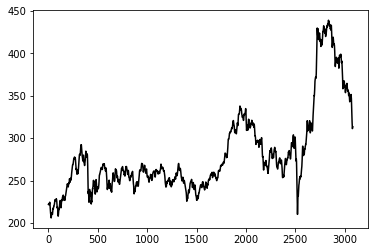

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(data_done['5일 이평'], color='black')
plt.show()
plt.clf()

In [ ]:
route_new = "/content/drive/Shareddrives/공모공모/흑백_9696"

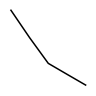

In [ ]:
fig, ax = plt.subplots()
x = 106 / fig.dpi  # 가로 길이 (320 pixel)
y = 109 / fig.dpi  # 세로 길이 (240 pixel)
fig.set_figwidth(x)
fig.set_figheight(y)
plt.plot(data_done['5일 이평'][123:128], color = 'black')
plt.axis('off')
plt.show()

In [ ]:
def set_figure_pixel_size (width, height, ppi):
    plt.figure(figsize=(width/float(ppi), height/float(ppi)), dpi=ppi)

In [ ]:
for i in range(5,n-3): 
  g[i] = data_done['5일 이평'][i-5:i]
  diff = (data_done['5일 이평'][i+3] - data_done['5일 이평'][i]) / data_done['5일 이평'][i]
  if diff < -0.015:
    file_route = route_new + "/-1.5미만"
  elif diff < 0.015:
    file_route = route_new + "/-1.5이상1.5미만"
  else:
    file_route = route_new + "/1.5이상"

  set_figure_pixel_size(96, 96, 72)
  plt.plot(g[i], color='black')
  plt.axis('off')  
  plt.savefig(file_route+ f"/img_{i-5}", dpi=72)
  plt.clf()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

<Figure size 96x96 with 0 Axes>

#### 3-4. 이미지 테스트 데이터 생성

In [ ]:
data_kd = pd.read_csv("/content/drive/Shareddrives/공모공모/훈련테스트 데이터/코스닥 테스트 완성본.csv")

In [ ]:
n = len(data_kd['5일 이평'])
g = {}

In [ ]:
plt.plot(data_kd['5일 이평'], color='black')
plt.show()
plt.clf()

In [ ]:
route_test = "/content/drive/Shareddrives/공모공모/흑백_9696_test"

In [ ]:
fig, ax = plt.subplots()
x = 106 / fig.dpi  # 가로 길이 (320 pixel)
y = 109 / fig.dpi  # 세로 길이 (240 pixel)
fig.set_figwidth(x)
fig.set_figheight(y)
plt.plot(data_kd['5일 이평'][123:128], color = 'black')
plt.axis('off')
plt.show()

In [ ]:
for i in range(5,n-3): 
  g[i] = data_kd['5일 이평'][i-5:i]
  diff = (data_kd['5일 이평'][i+3] - data_kd['5일 이평'][i]) / data_kd['5일 이평'][i]
  if diff < -0.015:
    file_route = route_test + "/-1.5미만"
  elif diff < 0.015:
    file_route = route_test + "/-1.5이상1.5미만"
  else:
    file_route = route_test + "/1.5이상"

  set_figure_pixel_size(96, 96, 72)
  plt.plot(g[i], color='black')
  plt.axis('off')  
  plt.savefig(file_route + f"/img_{i-5}", dpi=72)
  plt.clf()

### 4. 모델 구축 및 학습

#### 4-1. CNN 모델을 활용한 그래프 분석 모델 구성

In [ ]:
#이미지 사이즈, 배치 사이즈 지정

BATCH_SIZE = 128
IMG_SIZE = (96, 96)

In [ ]:
#Train dataset과 Validation dataset 설정

train_dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/Shareddrives/공모공모/흑백_9696',
                                                            shuffle=True,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=.2,
                                                            subset = 'training',
                                                            seed = 777)

val_dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/Shareddrives/공모공모/흑백_9696',
                                                            shuffle=True,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=.2,
                                                            subset = 'validation',
                                                            seed = 777)

Found 3076 files belonging to 3 classes.
Using 2461 files for training.
Found 3076 files belonging to 3 classes.
Using 615 files for validation.


In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet',
                                                  classes = 3,
                                                  classifier_activation='softmax')

for layer in base_model.layers[:-50]:
  layer.trainable = False


for layer in base_model.layers[-50:]:
  layer.trainable = True

In [ ]:
# CNN 모델 구축
inputs = tf.keras.Input(shape=(96, 96, 3))
x = preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(30, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#모델 피팅 진행
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
20/20 [==============================] - 1437s 46s/step - loss: 0.8955 - accuracy: 0.7412 - val_loss: 0.6289 - val_accuracy: 0.8244
Epoch 2/20
20/20 [==============================] - 7s 310ms/step - loss: 0.6580 - accuracy: 0.8050 - val_loss: 0.5868 - val_accuracy: 0.8244
Epoch 3/20
20/20 [==============================] - 7s 312ms/step - loss: 0.6493 - accuracy: 0.8050 - val_loss: 0.5889 - val_accuracy: 0.8244
Epoch 4/20
20/20 [==============================] - 7s 314ms/step - loss: 0.6491 - accuracy: 0.8050 - val_loss: 0.5911 - val_accuracy: 0.8244
Epoch 5/20
20/20 [==============================] - 7s 316ms/step - loss: 0.6394 - accuracy: 0.8050 - val_loss: 0.5913 - val_accuracy: 0.8244
Epoch 6/20
20/20 [==============================] - 7s 317ms/step - loss: 0.6348 - accuracy: 0.8050 - val_loss: 0.5893 - val_accuracy: 0.8244
Epoch 7/20
20/20 [==============================] - 7s 316ms/step - loss: 0.6298 - accuracy: 0.8050 - val_loss: 0.5890 - val_accuracy: 0.8244
Epoch

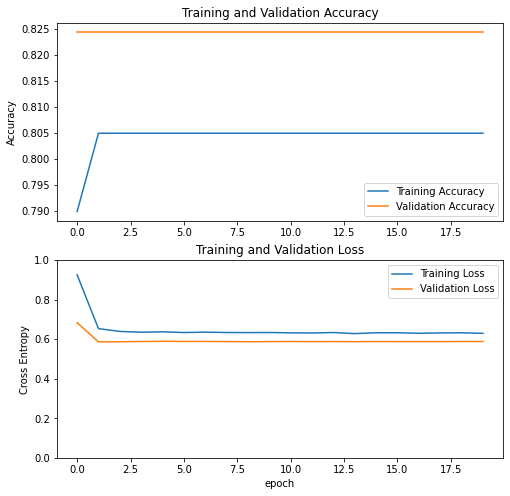

In [ ]:
# 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0.9,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### 4-2. CNN+LSTM 모델 구현하기

In [ ]:
# 저장해둔 데이터 불러오기
data = pd.read_csv('/content/drive/Shareddrives/공모공모/훈련테스트 데이터/날짜종가이평.csv')

In [ ]:
data.head()

,날짜,종가,5일 이평
0,20100104,223.49,221.878
1,20100105,222.84,222.112
2,20100106,224.67,222.640
3,20100107,221.31,222.834
4,20100108,222.66,222.994


            날짜      종가    5일 이평
0     20100104  223.49  221.878
1     20100105  222.84  222.112
2     20100106  224.67  222.640
3     20100107  221.31  222.834
4     20100108  222.66  222.994
...        ...     ...      ...
3079  20220624  312.07  311.284
3080  20220627  316.20  311.636
3081  20220628  319.11  312.182
3082  20220629  312.86  313.138
3083  20220630  307.20  313.488

[3084 rows x 3 columns]


,count,mean,std,min,25%,50%,75%,max
날짜,3084.0,2.015809e+07,36188.040570,2.010010e+07,2.013020e+07,2.016032e+07,2.019052e+07,2.022063e+07
종가,3084.0,2.815321e+02,51.200521,1.992800e+02,2.495075e+02,2.637400e+02,2.988175e+02,4.404000e+02
5일 이평,3084.0,2.814732e+02,51.143712,2.060220e+02,2.494055e+02,2.637340e+02,2.982110e+02,4.390280e+02


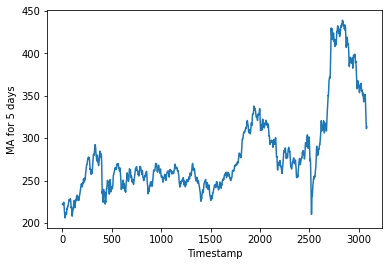

In [ ]:
plt.plot(data['5일 이평'], label="5일 이동평균")
plt.xlabel("Timestamp")
plt.ylabel("MA for 5 days")
df = data
print(df)

df.describe().transpose()

###**train**

In [ ]:
# LSTM 학습 가능한 형태로 데이터 재가공
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=10
for i in range(1 , len(df) - window_size -1 , 1):
    last = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - last) / last)
    temp2.append((df.iloc[i + window_size, 2] - last) / last)
    X.append(np.array(temp).reshape(10, 1))
    Y.append(np.array(temp2).reshape(1, 1))

#여기서는 시계열성을 반영하여 분석하기 위해 shuffle=False로 둔다.
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
val_X = np.array(x_val)
train_Y = np.array(y_train)
val_Y = np.array(y_val)

train_X = train_X.reshape(train_X.shape[0],1,10,1)
val_X = val_X.reshape(val_X.shape[0],1,10,1)

print(len(train_X))
print(len(val_X))

2457
615


In [ ]:
train_X.shape

(2457, 1, 10, 1)

In [ ]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

In [ ]:
model = tf.keras.Sequential()
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 10, 1))))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(10, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(10, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [ ]:
history = model.fit(train_X, train_Y, validation_data=(val_X,val_Y), epochs=10,batch_size=40, verbose=1, shuffle =True)

Epoch 1/10
62/62 [==============================] - 21s 36ms/step - loss: 4.6920e-04 - mse: 4.6920e-04 - mae: 0.0161 - val_loss: 7.0015e-04 - val_mse: 7.0015e-04 - val_mae: 0.0174
Epoch 2/10
62/62 [==============================] - 1s 10ms/step - loss: 2.4743e-04 - mse: 2.4743e-04 - mae: 0.0118 - val_loss: 3.9356e-04 - val_mse: 3.9356e-04 - val_mae: 0.0128
Epoch 3/10
62/62 [==============================] - 1s 11ms/step - loss: 1.8113e-04 - mse: 1.8113e-04 - mae: 0.0100 - val_loss: 3.3999e-04 - val_mse: 3.3999e-04 - val_mae: 0.0125
Epoch 4/10
62/62 [==============================] - 1s 11ms/step - loss: 1.6925e-04 - mse: 1.6925e-04 - mae: 0.0095 - val_loss: 2.1185e-04 - val_mse: 2.1185e-04 - val_mae: 0.0100
Epoch 5/10
62/62 [==============================] - 1s 11ms/step - loss: 1.4892e-04 - mse: 1.4892e-04 - mae: 0.0086 - val_loss: 1.7121e-04 - val_mse: 1.7121e-04 - val_mae: 0.0082
Epoch 6/10
62/62 [==============================] - 1s 10ms/step - loss: 1.1976e-04 - mse: 1.1976e-04 - 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 8, 64)         256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 6, 128)        24704     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 4, 64)         24640     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 2, 64)         0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 128)           0

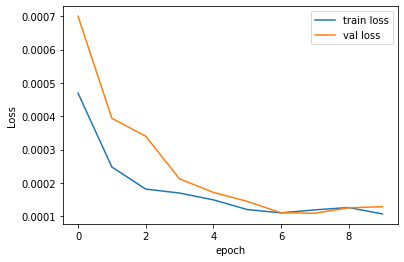

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

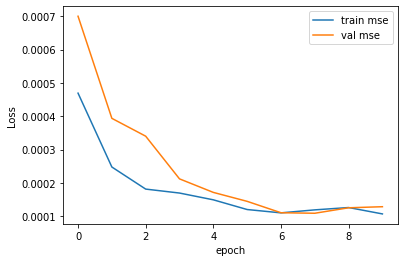

In [ ]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

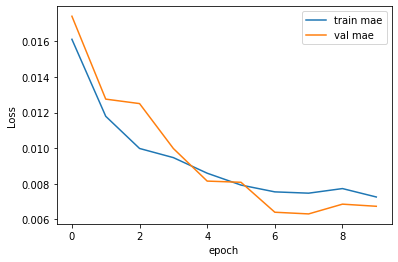

In [ ]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 8, 64)         256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 6, 128)        24704     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 4, 64)         24640     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 2, 64)         0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 128)           0

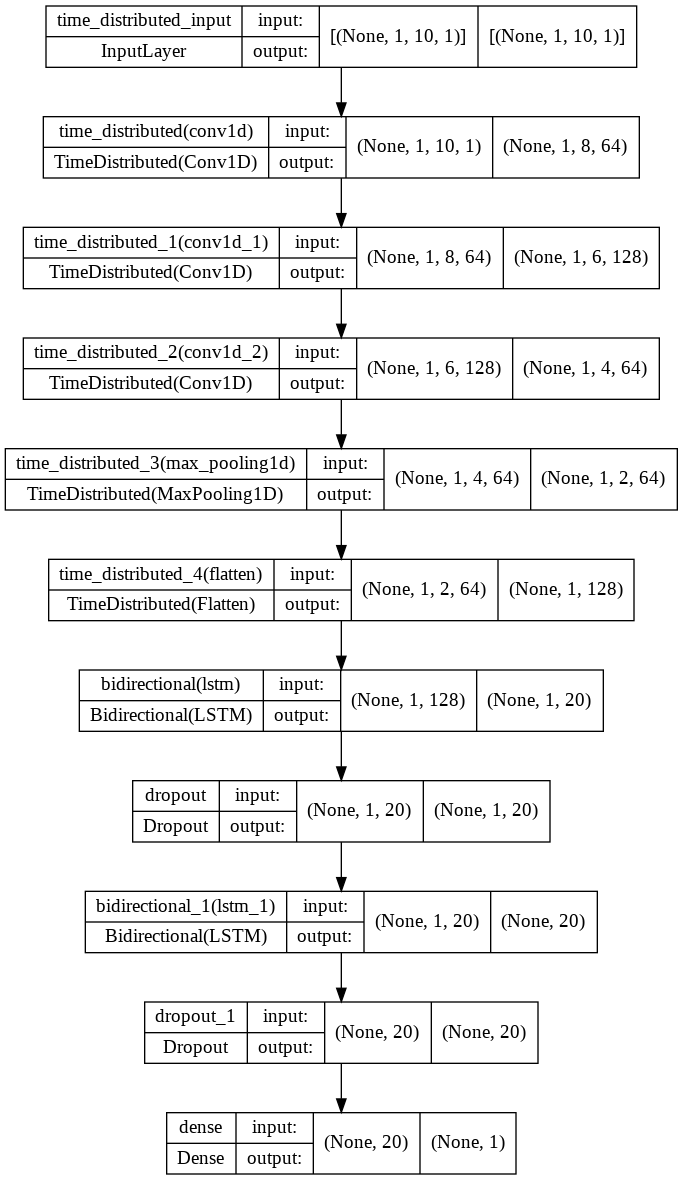

In [ ]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.evaluate(val_X, val_Y)

20/20 [==============================] - 0s 5ms/step - loss: 1.2821e-04 - mse: 1.2821e-04 - mae: 0.0067


[0.00012820593838114291, 0.00012820593838114291, 0.006740978453308344]

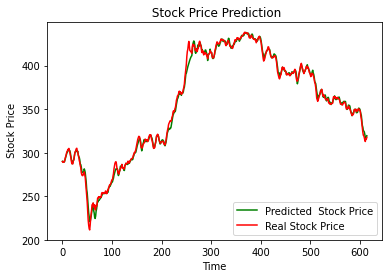

In [ ]:
predicted  = model.predict(val_X)
val_label = val_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(val_X)):
    temp = data.iloc[j,2]
    val_label[j - len_t] = val_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(val_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()


### 5. 결론 도출

결과적으로, train accuracy 는 80.5%의 정확도를 보였으며, validation 결과 82.44%의 정확도를 보였다. 예상보다는 낮은 정확도를 보였는데, 이는 local minima problem과 데이터 양이 부족했기에 발생한 문제로 파악하였다. 따라서, 본선 진출 시 해당 문제를 해결하여 보다 높은 정확도를 보일 수 있도록 발전시키고자 한다. 

다음으로, 정확한 숫자 예측값도 함께 제시하기 위해 CNN과 LSTM 모델을 결합한 추가적인 regression 모델을 생성했다. 앞선 이미지 분류모델이 증가/하락/횡보 여부를 예측할 때 정확한 값을 제시할 수 없으므로 추가적 모델을 통해 정확한 값을 제시할 수 있도록 하였다. 해당 모델의 경우, 0.0001의 낮은 mse 값을 보이며 정확한 예측이 가능할 것임을 시사했다.


추가로, 본래 서비스의 궁극적 목적인 파생상품 가격 변동 예측 및 제시를 위한 인터페이스 구성 역시 진행해나가고자 한다. 